#Importing libaries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

#Functions

In [2]:
def show_image(image, title="title", cmap_type="gray"):
    plt.imshow(image, cmap_type)
    plt.title(title)

In [3]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [4]:
def get_src_dst(image):
    src = [595, 452], \
          [685, 452], \
          [1110, image.shape[0]], \
          [220, image.shape[0]]
    line_dst_offset = 100
    dst = [src[3][0] + line_dst_offset, 0], \
            [src[2][0] - line_dst_offset, 0], \
            [src[2][0] - line_dst_offset, src[2][1]], \
            [src[3][0] + line_dst_offset, src[3][1]]
    
    return src, dst

In [5]:
def masked_image(image):
    offset = 100
    mask_poly =np.array([[(0 + offset, image.shape[0]),
                            (image.shape[1] / 2.3, image.shape[0] / 1.65),
                            (image.shape[1] / 1.7, image.shape[0] / 1.65),
                            (image.shape[1], image.shape[0])]],
                          dtype=int)
    mask_img = np.zeros_like(image)
    ignore_mask_color = 255
    cv2.fillPoly(mask_img, mask_poly, ignore_mask_color)
    masked_edges = cv2.bitwise_and(image, mask_img)
    return masked_edges

In [6]:
def warp(image, src, dst):

    src = np.float32([src])
    dst = np.float32([dst])
    
    return cv2.warpPerspective(image, cv2.getPerspectiveTransform(src, dst),
                               dsize=image.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

In [7]:
def crop_image(image, region_of_interest_vertices):
    cropped_image = region_of_interest(
    image,
    np.array([region_of_interest_vertices], np.int32))
    return cropped_image

In [8]:
def get_warped_image_histogram(image):
    return np.sum(image[image.shape[0] // 2:, :], axis=0)

In [9]:
def sliding_window(image, n_windows=9):    
    # Allow image to be RGB to display sliding windows.
    image_with_windows = np.dstack((image, image, image)) * 255
    
    # Get Binary image histogram    
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
    # Get Center of left and right peaks.
    midpoint = histogram.shape[0] // 2

    leftx_base = np.argmax(histogram[:midpoint]) #325
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint #1050
    
    # Calculate window height.
    window_height = image.shape[0] // n_windows
    
    # Get indicies that map to non zero values.
    non_zero_y, non_zero_x = map(lambda x: np.array(x), image.nonzero())
    
    margin = 50 # Width of sliding window.
    min_pixels = 50 # Min amount of pixels that match inside the window to detect a lane.
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_indicies = []
    right_lane_indicies = []
    
    for window in range(n_windows):
        # Calculate window vertices positions.
        win_y_low = image.shape[0] - (window + 1) * window_height # Y coordinate of top corners. 
        win_y_high = image.shape[0] - window * window_height # Y coordinate of bottom corners.
        win_xleft_low = leftx_current - margin # X coordinate of left side of the window at the left side of the lane.
        win_xleft_high = leftx_current + margin # X coordinate of right side of the window at the left side of the lane.
        win_xright_low = rightx_current - margin # X coordinate of left side of the window at the right side of the lane.
        win_xright_high = rightx_current + margin # X coordinate of right side of the window at the right side of the lane.
        
       
        good_left_indicies = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xleft_low) & (
            non_zero_x < win_xleft_high)).nonzero()[0] # Check if index is inside the left window.
        good_right_indicies = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xright_low) & (
            non_zero_x < win_xright_high)).nonzero()[0] # Check if index is inside the right window.
        
        
        left_lane_indicies.append(good_left_indicies)
        right_lane_indicies.append(good_right_indicies)
        
          # Draw green rectangle at current windows.
        cv2.rectangle(image_with_windows, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(image_with_windows, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        # Shift left to the mean.
        if len(good_left_indicies) > min_pixels:
            leftx_current = int(np.mean(non_zero_x[good_left_indicies]))
        if len(good_right_indicies) > min_pixels:
            rightx_current = int(np.mean(non_zero_x[good_right_indicies]))
    
    left_lane_indicies = np.concatenate(left_lane_indicies)
    right_lane_indicies = np.concatenate(right_lane_indicies)

    # Pixels that matched in the left side of the lane.
    left_x = non_zero_x[left_lane_indicies]
    left_y = non_zero_y[left_lane_indicies]
    
    # Pixels that matched in the right side of the lane.
    right_x = non_zero_x[right_lane_indicies]
    right_y = non_zero_y[right_lane_indicies]

    # Fit the points using a second degree polynomial.
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
        
    return image_with_windows, left_fit, right_fit

In [10]:
def draw_lines_and_fill(image, warped_image, left_fit, right_fit, src, dst):
    
    # Make a zero like copy of warped image.
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    
    # Make rgb image of zeros.
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Create a y axis.
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    ploty = ploty[ploty.shape[0] // 2:] # zwdt dh
        
    # Left line polynomial.
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    # Right Line polynomial.
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp_center, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, dst, src)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.2, 0)

    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.polylines(color_warp_lines, np.int_([pts_left]), isClosed=False, color=(0, 0, 255), thickness=25)
    cv2.polylines(color_warp_lines, np.int_([pts_right]), isClosed=False, color=(0, 0, 255), thickness=25)
    newwarp_lines = warp(color_warp_lines, dst, src)

    result = cv2.addWeighted(result, 1, newwarp_lines, 1, 0)

    return result, color_warp_lines

In [11]:
def thresholding(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    gray = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    mag_thresh=(3, 255)
    s_thresh=(170, 255)
    sobel_binary = np.zeros(shape=gray.shape, dtype=bool)
    s_binary = sobel_binary
    combined_binary = s_binary.astype(np.float32)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
    sobely = 0
    #sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
    #show_image(sobelx)
    sobel_abs = np.abs(sobelx**2 + sobely**2)
    sobel_abs = np.uint8(255 * sobel_abs / np.max(sobel_abs))
    sobel_binary[(sobel_abs > mag_thresh[0]) & (sobel_abs <= mag_thresh[1])] = 1

    # Threshold color channel
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.uint8(255 * combined_binary / np.max(combined_binary))
    return combined_binary

In [12]:
def measure_curvature(image, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [13]:
def measure_position(image, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = image.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the felt hand side of the center of the lane
    veh_pos = ((image.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    return veh_pos

In [14]:
def create_y_axis(image, left_fit, right_fit):
    # Create a y axis.
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    # Left line polynomial.
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    # Right Line polynomial.
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

In [15]:
def put_text(final_image , left_curverad , right_curverad , veh_pos):
    cv2.putText(final_image,'Curve Radius [m]: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(final_image,'Center Offset [m]: '+str(veh_pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    return final_image

In [16]:
def combine_output(result, combined_binary, warped_image, image_with_windows, inv_warp,cropped_image):
    combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_GRAY2RGB).astype(np.uint8)
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_GRAY2RGB).astype(np.uint8)
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2RGB).astype(np.uint8)
    image_with_windows = image_with_windows.astype(np.uint8)
    hor1 = np.concatenate((result, combined_binary, warped_image),axis=1)
    hor2 = np.concatenate((inv_warp, cropped_image, image_with_windows),axis=1)
    final = np.concatenate((hor1, hor2),axis=0)
    final = cv2.resize(final, (0, 0), None, result.shape[1] / final.shape[1], result.shape[0] / final.shape[0])

    return final

Input

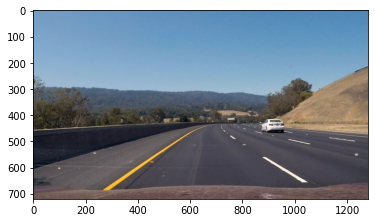

In [17]:
#Reading image
image = cv2.imread("./Project_data/test_images/test3.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Pipeline

In [18]:
def pipeline (image, debug=False):
    #Image shape and region of interest
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, height),
        (width / 2,400),
        (width, height),
    ]
    
    #Applying Thresholding
    combined_binary = thresholding(image)
    
    #Getting src and dst
    src,dst = get_src_dst(image)
    
    #Cropping the image
    cropped_image = crop_image(combined_binary, region_of_interest_vertices)
    
    #Applying perspective transform
    warped_image = warp(cropped_image, src, dst)
    
    #Sliding Window Function
    image_with_windows, left_fit, right_fit = sliding_window(warped_image)
    
    #Drawing lane lines and filling between them
    result, inv_warp = draw_lines_and_fill(image, warped_image, left_fit, right_fit, src, dst)
    
    #Calculating Curvature and position from center
    left_fitx, right_fitx, ploty = create_y_axis(image, left_fit, right_fit)
    left_curverad, right_curverad =  measure_curvature(warped_image, left_fitx, right_fitx, ploty)
    veh_pos = measure_position(warped_image, left_fit, right_fit)
    out_img = put_text(result , left_curverad , right_curverad , veh_pos)
    
    if not debug:
        return out_img
    
    #Combining images to display
    result_final = combine_output(out_img, combined_binary, warped_image, image_with_windows, inv_warp, cropped_image)
    
    #Final Output
    return result_final

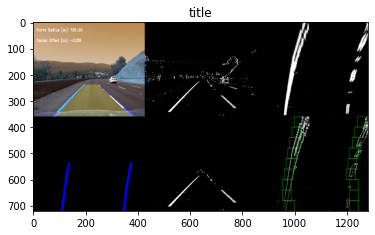

In [19]:
#Testing Pipeline and displaying output
final_image = pipeline(image, debug=True)
show_image(final_image)

In [20]:
# Saving Output Video
video_output = 'final.mp4'
clip = VideoFileClip('./Project_data/project_video.mp4')
output_clip = clip.fl_image(lambda image: pipeline(image, debug=True))
%time output_clip.write_videofile(video_output, audio=False)

Moviepy - Building video final.mp4.
Moviepy - Writing video final.mp4



Moviepy - Done !
Moviepy - video ready final.mp4
CPU times: user 2min 31s, sys: 21.6 s, total: 2min 53s
Wall time: 1min 1s


In [32]:
#Displaying video
cap = cv2.VideoCapture('./Project_data/project_video.mp4')

while cap.isOpened():
    ret, i = cap.read()

    if i is None:
        break
    cv2.imshow('frame', pipeline(i, debug=True))

    # img_array.append(img)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()